In [12]:
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
import torch.utils.data as data
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import imp
import torchaudio
import torchvision as tv
import matplotlib.pyplot as plt
from IPython.display import Audio
import os, random
import pandas as pd
import mir_utils as miru
from torch.utils.data import Dataset, DataLoader
import librosa
import librosa.display
import pytorch_models
imp.reload(miru)
imp.reload(pytorch_models)
SR=44100
#functions
spec=torchaudio.functional.spectrogram

db_name="sample_swap_free_final"

# audio_frames=miru.audioFrames(loadCache=True)

audio_frames=pd.concat([miru.audioFrames(db_name="radar",loadCache=True),miru.audioFrames(db_name="sample_swap",loadCache=True)])
synth_noise_frames=miru.audioFrames(db_name="noise",loadCache=True)
def getMeanLength(x):
    gl=x.apply(lambda z: len(z["audio"]),axis=1)
    print(gl.mean()/SR,gl.mean(),x["label"].iloc[0])

def getRandAud():
    classes=os.listdir("./dk_data/")
    rand_class=random.choice(classes)
#     rand_class="synth_noise"
    rand_sample=random.choice(os.listdir("./dk_data/%s/"%(rand_class,)))
    return "./dk_data/"+rand_class+"/"+rand_sample
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# list(zip(uniques,range(0,len(uniques))))

audio_frames=audio_frames.loc[~audio_frames["label"].isin(["guitar","piano"])]        
#split the dataframe into 2 seperate ones:
drum_frames=audio_frames.loc[~audio_frames["label"].isin(["synth_noise","guitar","piano","noise","voc","electronic_hits"])]


not_drum_frames=synth_noise_frames[0:1000]


./drum_dbs/radar ./drum_dbs/radar.dill
./drum_dbs/sample_swap ./drum_dbs/sample_swap.dill
./drum_dbs/noise ./drum_dbs/noise.dill


In [132]:


#drum only classification
# audio_frames["label_num"].isin(not_drum_labels)
dLabels, dUniques=pd.factorize(drum_frames["label"].tolist())
ndLabels, ndUniques=pd.factorize(not_drum_frames["label"].tolist())

drum_frames["label_num"]=dLabels
not_drum_frames["label_num"]=ndLabels+len(dUniques)

allU=np.concatenate([dUniques,ndUniques])
lmap=list(zip(allU,range(len(allU))))

#get weights for each group
# x=drum_frames.groupby(["label"]).agg("count")["path"]
y=audio_frames.groupby(["label"]).agg("count")["path"]
print(y)
weights=torch.tensor([1000/w for w in y.tolist()])


label
clap                401
electronic_hits     235
hat                1275
kick               1334
noise               168
rim                  82
shake               116
snare              1035
tom                 167
voc                  73
Name: path, dtype: int64


,label,path,audio,label_num
0,hat,./drum_dbs/radar/hat/Techno_Closed_Hat_03.wav,"[5.555153e-05, -0.02053535, -0.012322068, 0.02...",0
1,hat,./drum_dbs/radar/hat/RDM_Analog_MT40-OpHat01.wav,"[0.0, -1.8537045e-05, -2.7954578e-05, -3.27825...",0
2,hat,./drum_dbs/radar/hat/RDM_Copicat_MT40-ClHat.wav,"[0.0, 0.00038862228, 0.0007919073, 0.000977039...",0
3,hat,./drum_dbs/radar/hat/ClosedHat08.wav,"[-0.00015258789, 0.13226318, -0.32937622, -0.1...",0
4,hat,./drum_dbs/radar/hat/Closed_Hat_15.wav,"[0.035823524, 0.0041125417, 0.0051293373, 0.00...",0
...,...,...,...,...
1137,kick,./drum_dbs/sample_swap/kick/kick-swish.wav,"[0.076187134, 0.078323364, 0.09152222, 0.09278...",5
1138,kick,./drum_dbs/sample_swap/kick/ginormous-distorte...,"[-9.1552734e-05, -9.1552734e-05, 0.0047912598,...",5
1139,kick,./drum_dbs/sample_swap/kick/bunchakiks46.wav,"[4.2333937e-05, 0.0010587487, 0.0010352005, 0....",5
1140,kick,./drum_dbs/sample_swap/kick/ec-kik028.wav,"[-0.009216309, -0.05807495, -0.09729004, -0.13...",5


In [133]:
class audioDataset(torch.utils.data.Dataset):
    def __init__(self,audio_frame,root_dir, task="keep_all",transform=None):
        self.root_dir=root_dir
        self.task=task
        self.audio_frame=audio_frame
        self.transform = transform
        self.minLength=SR
#         self.minLength=SR//4
        self.frame_pruning()
    def __len__(self):
        return len(self.audio_frame)
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        rows=self.audio_frame.iloc[idx]

        signals,labels=rows["audio"].tolist()[0:SR],rows["label_num"].tolist()
        signals,labels=torch.tensor(signals),torch.tensor(labels)
        
        nz=np.max((self.minLength-signals.shape[0],0))
        signals=torch.cat([signals[0:self.minLength],torch.zeros(nz)],dim=0)

        sound={"signal":signals,"label":labels,"path":rows["path"],"drum_type":rows["label"]}
        
        if self.transform:
            sound = self.transform(sound)

        return sound
    
    def frame_pruning(self):
        #drum vs not drum classification:
        drum_label_numbers=range(len(dUniques))
        if self.task=="dvn":
            self.audio_frame.loc[self.audio_frame["label_num"].isin(drum_label_numbers),"label_num"]=0
            self.audio_frame.loc[~self.audio_frame["label_num"].isin(drum_label_numbers),"label_num"]=1
            self.audio_frame.loc[self.audio_frame["label"]=="synth_noise","label_num"]=1 #same as last thing prolly...
        #drum type classification
        if self.task=="dvd":
            self.audio_frame=self.audio_frame.loc[self.audio_frame["label_num"].isin(drum_label_numbers)]
        if self.task=="keep_all":
            pass
            
ds=audioDataset(pd.concat([drum_frames,not_drum_frames]),"./",task="dvn",)

all_frames=pd.concat([drum_frames,not_drum_frames])
train=all_frames.sample(frac=0.80,random_state=420) #random state is a seed value
test=all_frames.drop(train.index)

torch.Size([30, 20])
('hat', 0) tensor(0) 44100


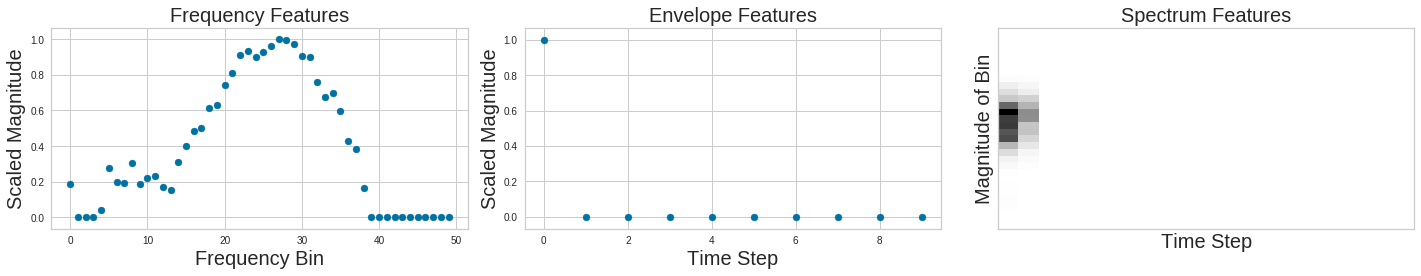

In [150]:
FREQ_BINS=30
TIME_STEPS=20
#defining transformations
class freqTrans(object):
    def __init__(self,num_mels=50,SR=SR):
        self.num_mels=num_mels
        self.ampT=torchaudio.transforms.AmplitudeToDB(stype='power', top_db=30)
        self.melF=torchaudio.transforms.MelScale(n_mels=self.num_mels, sample_rate=SR, f_min=30.0, f_max=None, n_stft=None)
        
    def __call__(self, sample):
        wf,label=sample["signal"],sample["label"]
        wf=wf.reshape(-1,len(wf))
        sample_length=SR//4
        wf=wf[:,0:24000]
        num_bins=wf[0].shape[0]
        win_length=num_bins
        hop_step=sample_length//(self.num_mels)
        window=torch.tensor([1]*win_length)
        s=spec(wf, 100, window, num_bins, hop_step, win_length,2,normalized=False)
        s=self.melF(s)
        s=self.ampT(s)
        freq=s.sum(axis=0).sum(axis=1)
        freq=freq-freq.min()
        freq=freq/freq.max()
        freq[torch.isnan(freq)]=0
        return {"feats":freq.detach(),"label":label}

class envTrans(object):
    def __init__(self,num_mels=10,SR=SR):
        self.env_size=9
        self.num_mels=num_mels
        self.amp=torchaudio.transforms.AmplitudeToDB(stype='power', top_db=60)
        self.melEnv=torchaudio.transforms.MelScale(n_mels=self.num_mels, sample_rate=SR, f_min=30.0, f_max=None, n_stft=None)
#         self.norm= transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    def __call__(self, sample):
        wf,label=sample["signal"],sample["label"]
        
        wf=wf.reshape(-1,len(wf))
        sample_length=SR
        num_bins=wf[0].shape[0]
        win_length=SR//20
        hop_step=SR//self.env_size
        window=torch.tensor([1]*win_length)
        s=spec(wf, 0, window,win_length, hop_step, win_length,2,normalized=False)
        s=self.melEnv(s)
        s=self.amp(s)
#         s=self.norm(s)
        #normalizing
        env=s.sum(axis=0).sum(axis=0)
        env=env-env.min()
        env=env/env.max()
        env[torch.isnan(env)]=0

        num_padding=torch.max(torch.tensor([self.env_size+1-env.shape[0],0]))
        env_vec=torch.cat([env.detach(),torch.zeros(num_padding)],dim=0)
        return {"feats":env_vec.detach(),"label":label}
    
#when i need both spec and env feats
class spec_and_env(object):
    def __init__(self,specTrans=None,envTrans=None):
        self.sT=specTrans
        self.eT=envTrans
    def __call__(self, sample):
            #will get meta data from spec
            return {"spec_trans_results":self.sT(sample),"env_trans_results":self.eT(sample)["feats"]}


class feats_and_env(object):
    def __init__(self,feat_mels=50,env_mels=10):
        self.ft=freqTrans(num_mels=feat_mels)
        self.et=envTrans(num_mels=env_mels)
    def __call__(self, sample):
            combined_feats=torch.cat((self.ft(sample)["feats"],self.et(sample)["feats"]))
            return {"feats":combined_feats,"label":sample["label"]}
        

class specTrans(object):
    def __init__(self,num_mels=50,SR=SR,time_steps=20):
        self.num_mels=num_mels
        self.ampP=torchaudio.transforms.AmplitudeToDB(stype='power',top_db=60)
        self.melP=torchaudio.transforms.MelScale(n_mels=self.num_mels, sample_rate=SR,n_stft=None)
#         self.norm= transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        self.hop_step=time_steps-1
    def __call__(self, sample):
        
        wf,label,p,drum_type=sample["signal"],sample["label"],sample["path"],sample["drum_type"]
        wf=wf.reshape(-1,len(wf))
        sample_length=SR

        num_bins=wf[0].shape[0]
        win_length=SR//17
        hop_step=SR//self.hop_step
        window=torch.tensor([1]*win_length)
        s=spec(wf, 0, window, num_bins, hop_step, win_length,2,normalized=False)
        s=self.melP(s)
#         s=self.ampP(s)
        s = s - s.min()
        s = s/s.abs().max()

        freq=s
#         freq=self.norm(s)
        freq[torch.isnan(freq)]=0
        freq=freq[0]
        return {"feats":freq.detach(),"label":label,"path":p,"drum_type":drum_type}

#Apply each of the above transforms on sample.
fig = plt.figure(figsize=(20,4))
# while True:
sample = ds[np.random.randint(len(ds))]
#     print(sample["label"].item())
#     if sample["label"].item()==1:
#         break
# freq_train = audioDataset(train,".",task="dvd")
# f_train_loader= DataLoader(freq_train, batch_size=16, num_workers=1)
# sample=iter(f_train_loader).next()
# s={"signal":sample["signal"][0],"label":sample["label"][0],"path":sample["path"],"drum_type":sample["drum_type"]}
# sample=s
tfList=[freqTrans(50),envTrans(num_mels=10,SR=SR),specTrans(FREQ_BINS,time_steps=TIME_STEPS)]

for i, tsfrm in enumerate(tfList):
    transformed_sample = tsfrm(sample)
    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ft=transformed_sample["feats"]
    if i==0:
        plt.title("Frequency Features",fontsize=20)
        plt.xlabel("Frequency Bin",fontsize=20)
        plt.ylabel("Scaled Magnitude",fontsize=20)
                   
        plt.scatter(y=ft,x=range(0,len(ft)))
    if i==1:
        plt.title("Envelope Features",fontsize=20)
        plt.xlabel("Time Step",fontsize=20)
        plt.ylabel("Scaled Magnitude",fontsize=20)            
        plt.scatter(y=ft,x=range(0,len(ft)))
    if i==2:
        print(ft.shape,)
        sf=ft.detach().numpy()
        ft=ft.detach().numpy()
        plt.title("Spectrum Features",fontsize=20)
        librosa.display.specshow(sf,cmap='gray_r',)
        plt.xlabel("Time Step",fontsize=20)
        plt.ylabel("Magnitude of Bin",fontsize=20)

#         plt.savefig("./plots/ff3.pdf",bbox_inches = "tight")
# plt.show()
print(lmap[transformed_sample["label"].item()],transformed_sample["label"],len(sample["signal"]))


Audio(sample["signal"],rate=SR,autoplay=True)


# SPEC ENCODER WITH CNN

In [16]:
FREQ_BINS = 30
TIME_STEPS = 20

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pt=tv.transforms.Compose([specTrans(FREQ_BINS,time_steps=TIME_STEPS)])

train=all_frames.sample(frac=0.80,random_state=420) #random state is a seed value
test=all_frames.drop(train.index)
spec_data_train = audioDataset(train,".","dvn", transform=pt)
spec_data_test = audioDataset(test,".",task="dvn", transform=pt)
spec_train_loader= DataLoader(spec_data_train, batch_size=64,shuffle=True, num_workers=32)
spec_test_loader= DataLoader(spec_data_test, batch_size=8,shuffle=True, num_workers=6)
print(len(spec_data_train),len(spec_data_test))
train_synthless=train[train["label_num"]==0]
test_synthless=test[test["label_num"]==0]
class AE_Conv(nn.Module):
    def __init__(self,input_shape,compression_dim,dropout_rate=0.5,num_channels=5):
        super(AE_Conv, self).__init__()
        self.W=input_shape[0]
        self.H=input_shape[1]

        self.dropout = nn.Dropout(dropout_rate)
        self.Encoder_Conv= nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=num_channels, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.encoder_output_layer = nn.Linear(
            in_features=(self.H//2 * self.W//2) * 8, out_features=compression_dim
        )
        self.decoder_hidden_layer = nn.Linear(
            in_features=compression_dim, out_features=256
        )
        self.decoder_output_layer = nn.Linear(
            in_features=256, out_features=self.W*self.H)
        
    def forward(self, features):
        features=features.reshape([-1,1,self.W,self.H])
        activation = self.Encoder_Conv(features)
        activation = self.dropout(torch.relu(activation))
        activation = activation.reshape(activation.size(0), -1)
        code = self.encoder_output_layer(activation)
        code = torch.relu(code)
        self.encoding=code
        activation = self.decoder_hidden_layer(code)
        activation = torch.relu(activation)
        activation = self.decoder_output_layer(activation)
        reconstructed = torch.relu(activation)
        return reconstructed
def model_loader(m,p):
    s=torch.load(p) 
    m.load_state_dict(s)
    m.to(device)
    return m

4328 460


/home/asalimi/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [17]:
#optimized params
learning_rate = 0.0011451089315356296
dropout_rate = 0.5
latent_size = 64
FREQ_BINS = 30
TIME_STEPS = 20
hidden_layers = 2
l2 = 3.2473701348597023e-06


spec_dimension=FREQ_BINS*TIME_STEPS

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# pt=tv.transforms.Compose([specTrans(FREQ_BINS,time_steps=TIME_STEPS)])

#make dataloader 
ptTune=tv.transforms.Compose([specTrans(FREQ_BINS,time_steps=TIME_STEPS)])
spec_data_train_nosynth = audioDataset(train_synthless,".",task="dvn", transform=ptTune)
spec_train_nosynth_loader= DataLoader(spec_data_train_nosynth, batch_size=16,shuffle=True, num_workers=8)
spec_data_test_nosynth = audioDataset(test_synthless,".",task="dvn", transform=ptTune)
spec_test_nosynth_loader= DataLoader(spec_data_test_nosynth, batch_size=16,shuffle=True, num_workers=8)

model = AE_Conv(input_shape=[FREQ_BINS,TIME_STEPS],compression_dim=latent_size,dropout_rate=dropout_rate,num_channels=5).to(device)

#train


optimizer = optim.Adam(model.parameters(), lr=learning_rate,weight_decay=l2)
df=pd.DataFrame(columns=["epoch","train_loss","test_loss"])

# mean-squared error loss
criterion = nn.MSELoss()
epochs=100
for epoch in range(epochs):
    loss = 0
    for batch_features in spec_train_nosynth_loader:
        batch_features=batch_features["feats"]
        batch_features = batch_features.view(-1, spec_dimension).to(device)
        optimizer.zero_grad()
        outputs = model(batch_features)
        train_loss = criterion(outputs, batch_features)
        train_loss.backward()
        optimizer.step()
        loss += train_loss.item()

    loss = loss / len(spec_train_nosynth_loader)
    test_loss=0
    with torch.no_grad():
        for batch_features in spec_test_nosynth_loader:
            batch_features=batch_features["feats"]
            batch_features = batch_features.view(-1, spec_dimension).to(device)
            outputs = model(batch_features)
            temp_loss = criterion(outputs, batch_features)
            test_loss += temp_loss.item()
    test_loss = test_loss / len(spec_test_nosynth_loader) 
  
    df.loc[len(df)]=[epoch,loss,test_loss]

    print("epoch : {}/{}, loss = {:.6f}, test_loss = {:.6f}".format(epoch, epochs, loss,test_loss))
    model_specs='embed_%s_%d_%d'%(db_name,latent_size,epoch)
    df.to_csv("./csvs/training/"+"both"+".csv")
    if epoch%5==0:
        print("saving")
        torch.save(model.state_dict(),'./models/encode/embed_%s_%d_%d.pt'%(db_name,latent_size,epoch))
    



KeyboardInterrupt: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])
def imshow(img,saveas="delete.png"):

    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.savefig(saveas,format="png")
    plt.show()


#extracting features and putting them into the csv folder for plotting
m=model
dataiter=iter(spec_train_loader)
xy=dataiter.next()
images=xy["feats"].reshape([-1,1,FREQ_BINS,TIME_STEPS]).detach().cpu()

y=xy["label"].detach().cpu().numpy()

#get spectrograms depending on labels
drums=np.empty([1,FREQ_BINS,TIME_STEPS],np.float32)
not_drums=np.empty([1,FREQ_BINS,TIME_STEPS], np.float32)
for i,ii in enumerate(y):

    if ii==0:
        drums=np.vstack((drums,images[i]))
    else:
        not_drums=np.vstack((not_drums,images[i]))
drums=torch.tensor(drums.reshape([-1,1,FREQ_BINS,TIME_STEPS]))
not_drums=torch.tensor(not_drums.reshape([-1,1,FREQ_BINS,TIME_STEPS]))



[]

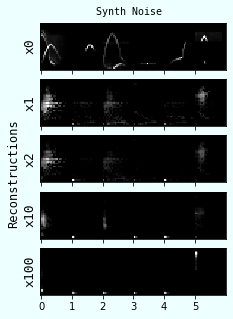

In [77]:
from PIL import Image
import matplotlib.ticker as ticker

num_plots=5

# d="Drums"
d="Synth Noise"
fig, axes = plt.subplots(nrows=5, ncols=1, sharex=True, sharey=True, figsize=(5,5),facecolor='#EEFFFF',)

fig.text(0.41, 0.91, d, va='center',fontsize=10,family="monospace")
fig.text(0.18, 0.32, 'Reconstructions', ha='center', rotation=90,fontsize=12,family="monospace")

# from transforms import RGBTransform # from source code mentioned above

recon_data=not_drums[1:7].to(device)
axnum=0
for i in range(101):
    if i in [0,1,2,10,100]:

        img=tv.utils.make_grid(recon_data.reshape([-1,1,FREQ_BINS,TIME_STEPS]).detach().cpu(),normalize=True,padding=1)
        npimg = img.numpy()
        ax=axes[axnum]
        axnum=axnum+1
#         ax.set_title("Loop %d"%i,fontsize=14)
        ax.yaxis.set_ticks([0,30])
        ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.f'))

        ax.get_yaxis().set_visible(True)
  
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])
        ax.yaxis.set_label_position("left")
        ax.set_ylabel("x%d"%i, rotation=90,size=13,family="monospace")
        
        
        flipped=np.transpose(npimg, (1, 2, 0))
        ax.imshow(np.flip(flipped,0))

        
    recon_data=m(recon_data.detach())
    
fig.axes[0].xaxis.set_ticks(np.arange(0,110,21))
fig.axes[0].xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.f'))
ticks = fig.axes[0].get_xticks()//21
fig.axes[0].set_xticklabels(ticks)  
    
# fig.axes[0].set_title("Original",fontsize=14)
# fig.axes[0].set_ylabel(None)



# fig.savefig(d+"_reacreation.pdf",format="pdf",bbox_inches='tight')

torch.Size([4, 600]) torch.Size([4, 1, 30, 20])


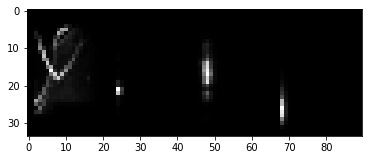

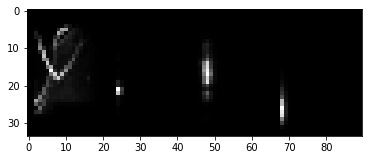

In [78]:
#making sure the flattening stuff works
batch_feats=xy["feats"][0:4]
bf_image=batch_feats.reshape([-1,1,FREQ_BINS,TIME_STEPS])
bf_flat=batch_feats.reshape([-1,FREQ_BINS*TIME_STEPS])
bf_unflat=bf_flat.reshape([-1,1,FREQ_BINS,TIME_STEPS]).detach().cpu()
print(bf_flat.shape,bf_unflat.shape)
imshow(tv.utils.make_grid(bf_unflat))
imshow(tv.utils.make_grid(bf_image))


In [92]:

encodings=np.empty([1,latent_size+1])
d={"feats":[],"label":[],"path":[],"drum_type":[]}
for i,xy in enumerate(audioDataset(all_frames,".",task="dvn", transform=pt)):
    print(str(i)+'\r', end="")
    x=xy["feats"]
    y=xy["label"]
    p=xy["path"]
    drt=xy["drum_type"]

    m(x.contiguous().view(-1,TIME_STEPS,FREQ_BINS).to(device))
    o=m.encoding.detach().cpu().numpy()
    d["feats"].append(list(o[0]))
    d["label"].append(y.item())
    d["path"].append(p)
    d["drum_type"].append(drt)

df=pd.DataFrame.from_dict(d)


encoding_csv_path="csvs/"+"radarANDfree"+"best64_60"+".csv"


df.to_csv(encoding_csv_path,index=False)

In [7]:
encoding_csv_path="csvs/"+"radarANDfree"+"best64_60"+".csv"


df.to_csv(encoding_csv_path,index=False)

NameError: name 'df' is not defined

In [56]:
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
from plotly.subplots import make_subplots
import pandas as pd
import time
from sklearn.manifold import TSNE, Isomap, LocallyLinearEmbedding, SpectralEmbedding
import plotly_express as px
import plotly.graph_objs as go
import ipywidgets as widgets
import os
from sklearn import preprocessing
from ast import literal_eval
import io
from PIL import Image

min_max_scaler = preprocessing.MinMaxScaler()
n_neighbors = 10

class interactive_graph():
    def __init__(self,df,grouping_by="label",title=""):
        p = px.scatter(df, x="v1",y="v2",color=grouping_by,hover_data=["path"],color_discrete_sequence=px.colors.qualitative.Dark24)
    
        for trace in p.data:
            trace.update(hoverinfo="none",hovertemplate= '')
        
        self.hover_data = widgets.Textarea()  
        #audio and img widgets
        self.aud=widgets.Audio(autoplay=True,loop=False,embedding=True)
        self.audioImg=widgets.Image(
            value=b'',
            format='png',
            width='30%', 
        )
        #####
        layout = go.Layout(hovermode=False,)
        self.fig  = go.FigureWidget(p)
        self.fig.update_layout(
            title={
                'text': title,
                'y':0.9,
                'x':0.5,
                'xanchor': 'center',
                'yanchor': 'top'})
        for f in self.fig.data:
            f.on_hover(self.hover_fn)
    
    
    def hover_fn(self,trace, points, state):
        if points.point_inds:
            ind = points.point_inds[0]
            drmName=trace.customdata[ind][0][2:]
            filename=os.getcwd()+"/"+drmName
            with open(filename,'rb') as f:
                audio_data = f.read()
            self.aud.value=audio_data
            self.hover_data.value = str(drmName)+"\n"
            self.audioImg.value=self.audDisplay(filename)
            
    def audDisplay(self,f):
        #this got annoying because widget only accepts byte version of images
        audio_array=librosa.load(f)
        signals=audio_array[0][0:SR]
        nz=np.max((SR-signals.shape[0],0))
        signals=np.concatenate([signals[0:SR],np.zeros(nz)]).astype("float32")

        sound={"signal":torch.tensor(signals),"label":'',"path":'',"drum_type":''}
        trns=specTrans(FREQ_BINS,time_steps=TIME_STEPS)
        ft=trns(sound)["feats"]
#         sf=ft.detach().numpy()[0]
        sf=ft.detach().numpy()
        #flip upside down
        sf=sf[-1:0:-1][:]
        plt.tight_layout()
        x=plt.imshow(sf)
        #convert to bytes so can be set to widget data
        buf = io.BytesIO()
        x.figure.savefig(buf, format='png')
        buf.seek(0)
        bufD=buf.getvalue()
        buf.close()    
        return bufD
def plotly_able_df(df):
    
    df["feats"]=df["feats"].apply(literal_eval)
    X=df["feats"]
    #convert series of arrays into a numpy array
    X=pd.DataFrame(X.to_list()).to_numpy()
    X = min_max_scaler.fit_transform(X)
    time_start = time.time()
    tsne = TSNE(n_components=2, random_state=0, perplexity=10, verbose=1)
#     tsne = Isomap(n_neighbors, n_components=2)
    # tsne = LocallyLinearEmbedding(n_neighbors,n_components=4)
    # tsne = SpectralEmbedding(n_neighbors=10,n_components=5,random_state=1)
    X_2d = tsne.fit_transform(X)
    df2=pd.concat([df["path"],df["label"],df["drum_type"],pd.Series(X_2d[:,0]),pd.Series(X_2d[:,1])],axis=1)
    df2.columns=["path","label","drum_type","v1","v2"]
    df2.label = df2.label.astype('str')
    return df2


df_8=plotly_able_df(pd.read_csv(encoding_csv_path))

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 5410 samples in 0.009s...
[t-SNE] Computed neighbors for 5410 samples in 2.015s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5410
[t-SNE] Computed conditional probabilities for sample 2000 / 5410
[t-SNE] Computed conditional probabilities for sample 3000 / 5410
[t-SNE] Computed conditional probabilities for sample 4000 / 5410
[t-SNE] Computed conditional probabilities for sample 5000 / 5410
[t-SNE] Computed conditional probabilities for sample 5410 / 5410
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 83.868187
[t-SNE] KL divergence after 1000 iterations: 1.547015


In [57]:
ig=interactive_graph(df_8,grouping_by="drum_type",title="64 dim embedding")
display(ig.fig,widgets.HBox([ig.hover_data,ig.aud,ig.audioImg]))

FigureWidget({
    'data': [{'customdata': array([['./drum_dbs/radar/hat/Techno_Closed_Hat_03.wav'],
         …

# train SVM for classification using the encoder as feature extractor

In [127]:
import numpy as np
import pandas as pd
import random
import mir_utils as miru
import sounddevice as sd
import matplotlib.pyplot as plt

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import svm
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix

mixed_frames=miru.audioFrames(db_name="dk_data",loadCache=True)

audio_frames=pd.concat([miru.audioFrames(db_name="radar",loadCache=True),miru.audioFrames(db_name="sample_swap",loadCache=True)])
synth_noise_frames=miru.audioFrames(db_name="noise",loadCache=True)




./drum_dbs/dk_data ./drum_dbs/dk_data.dill
./drum_dbs/radar ./drum_dbs/radar.dill
./drum_dbs/sample_swap ./drum_dbs/sample_swap.dill
./drum_dbs/noise ./drum_dbs/noise.dill


,label,path,audio,label_num
0,hat,./drum_dbs/radar/hat/Techno_Closed_Hat_03.wav,"[5.555153e-05, -0.02053535, -0.012322068, 0.02...",0
1,hat,./drum_dbs/radar/hat/RDM_Analog_MT40-OpHat01.wav,"[0.0, -1.8537045e-05, -2.7954578e-05, -3.27825...",0
2,hat,./drum_dbs/radar/hat/RDM_Copicat_MT40-ClHat.wav,"[0.0, 0.00038862228, 0.0007919073, 0.000977039...",0
3,hat,./drum_dbs/radar/hat/ClosedHat08.wav,"[-0.00015258789, 0.13226318, -0.32937622, -0.1...",0
4,hat,./drum_dbs/radar/hat/Closed_Hat_15.wav,"[0.035823524, 0.0041125417, 0.0051293373, 0.00...",0
...,...,...,...,...
995,synth_noise,./drum_dbs/noise/synth_noise/N3C1-1170-1.wav,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
996,synth_noise,./drum_dbs/noise/synth_noise/1952-4-YQLY.wav,"[0.0, -3.0517578e-05, -6.1035156e-05, -0.00036...",0
997,synth_noise,./drum_dbs/noise/synth_noise/PFEK-100-8.wav,"[0.0, 0.0006713867, 0.0061035156, 0.022827148,...",0
998,synth_noise,./drum_dbs/noise/synth_noise/5NU0-3325-1.wav,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0


In [146]:
drum_frames=audio_frames.loc[~audio_frames["label"].isin(["synth_noise","guitar","piano","noise","voc","electronic_hits"])]
not_drum_frames=synth_noise_frames[0:2000]

dLabels, dUniques=pd.factorize(drum_frames["label"].tolist())
ndLabels, ndUniques=pd.factorize(not_drum_frames["label"].tolist())
drum_frames["label_num"]=dLabels
not_drum_frames["label_num"]=ndLabels+len(dUniques)

allU=np.concatenate([dUniques,ndUniques])
lmap=list(zip(allU,range(len(allU))))
svn_frames=pd.concat([drum_frames,not_drum_frames])
#optimized params
learning_rate = 0.0011451089315356296
dropout_rate = 0.5
latent_size = 64
FREQ_BINS = 30
TIME_STEPS = 20
hidden_layers = 2
l2 = 3.2473701348597023e-06

m = AE_Conv(input_shape=[FREQ_BINS,TIME_STEPS],compression_dim=latent_size,dropout_rate=dropout_rate,num_channels=5).to(device)
m = model_loader(model,"models/encode/nosynth_64_195_0.000450.pt")


spec_env_trns=spec_and_env(specTrans(FREQ_BINS,time_steps=TIME_STEPS),envTrans(num_mels=10,SR=SR))

encodings=np.empty([1,latent_size+1])

d={"feats":[],"label":[],"path":[],"drum_type":[]}
for i,xy in enumerate(audioDataset(svn_frames,".",task="dvn", transform=spec_env_trns)):
    print(str(i)+'\r', end="")
   
    xy,e=xy["spec_trans_results"],xy["env_trans_results"] #annoying because im doing env and spec transforms

    x=xy["feats"]
    y=xy["label"]
    p=xy["path"]
    drt=xy["drum_type"]

    m(x.contiguous().view(-1,TIME_STEPS,FREQ_BINS).to(device))
    o=list(m.encoding.detach().cpu().numpy()[0])
    e=e.cpu().numpy()
#     o.extend(e) #comment if u dont want envelope features in there
    d["feats"].append(o)
    d["label"].append(y.item())
    d["path"].append(p)
    d["drum_type"].append(drt)

df=pd.DataFrame.from_dict(d)

p1="csvs/radarfree_best_emb.csv"
p2="csvs/radarfree_best_embenv.csv"
encoding_csv_path=p1
df.to_csv(encoding_csv_path,index=False)



/home/asalimi/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/asalimi/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [115]:

encoding_csv_path=p1

testFraction=0.2
#load same data as t-SNE but train SVM with it

label_groups="label"
# label_groups="drum_type"

df=pd.read_csv(encoding_csv_path)
df=df.loc[df["drum_type"].isin(["clap","hat","kick","snare","synth_noise"])]  
print(df.groupby([label_groups]).agg("count")["path"])#sample counts


#preperocessing
le = preprocessing.LabelEncoder()
le.fit(df[label_groups])
le.transform(df[label_groups])
df[label_groups]=le.transform(df[label_groups])
y_counts=df.groupby([label_groups]).agg("count")["path"] #for weights


#calculating weights
wdict=y_counts.to_dict()
total = sum(wdict.values(), 0.0)
class_weights = {k: (total-v) / total for k, v in wdict.items()}


y=df[label_groups]

df["feats"]=df["feats"].apply(literal_eval)
#df[feats] is an array of lists, needs conversion to ndArray
X=np.array([np.array(x) for x in df["feats"].to_numpy()])
wdict=y_counts.to_dict()
total = sum(wdict.values(), 0.0)
class_weights = {k: (total-v) / total for k, v in wdict.items()}


label
0    5045
Name: path, dtype: int64


In [ ]:

classifier = make_pipeline(StandardScaler(), SVC(gamma='auto',class_weight=class_weights))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testFraction, random_state=42,)

classifier.fit(X_train, y_train,)
y_pred = classifier.predict(X_test)

print(confusion_matrix(y_test,y_pred))
print(classification_report(le.inverse_transform(y_test),le.inverse_transform(y_pred)))

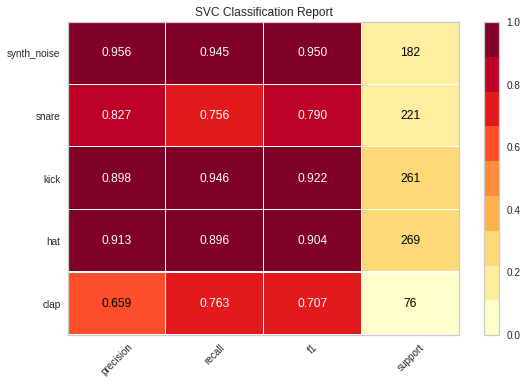

In [104]:
from yellowbrick.classifier import ClassificationReport,ConfusionMatrix

visualizer = ClassificationReport(classifier,classes=le.classes_, support=True)

visualizer.fit(X_train, y_train)  # Fit the visualizer and the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()


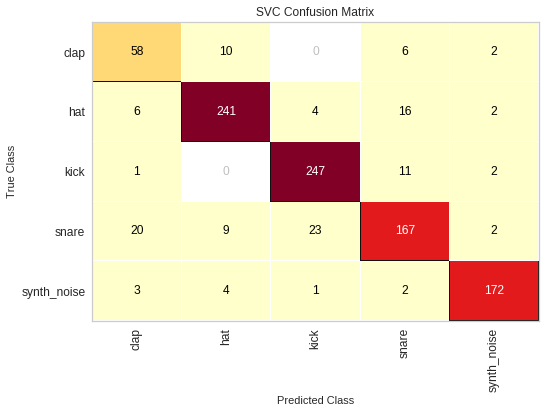

In [105]:
# The ConfusionMatrix visualizer taxes a model
cm = ConfusionMatrix(classifier, classes=le.classes_)

# Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
cm.fit(X_train, y_train)

# To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
# and then creates the confusion_matrix from scikit-learn.
cm.score(X_test, y_test)

# How did we do?
cm.show()